# Loading Packages and Setting up unified code frameworks

In [2]:
using DifferentialEquations, ModelingToolkit, MethodOfLines, DomainSets, Plots, NLsolve, Sundials, LoopVectorization, Polyester
using Integrals
using QuadGK

In [3]:
# gennerating ODEProblem
function probgeneration!(ratio::Function, γ::Function, initS::Function, initI::Function, dx=0.05)
    # Parameters, variables, and derivatives
    @parameters t x
    #@register γ(x)
    @parameters dS dI brn ϵ
    @variables S(..) I(..)

    Dt = Differential(t)
    Dx = Differential(x)
    Dxx = Differential(x)^2
    # 1D PDE and boundary conditions
    eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
        Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
    bcs = [S(0, x) ~ initS(x),
        I(0, x) ~ initI(x),
        Dx(S(t, 0)) ~ 0.0,
        Dx(S(t, 1)) ~ 0.0,
        Dx(I(t, 0)) ~ 0.0,
        Dx(I(t, 1)) ~ 0.0]
    # Space and time domains
    domains = [t ∈ Interval(0.0, 5.0),
        x ∈ Interval(0.0, 1.0)]
    # PDE system
    @named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 1.0])
    # Method of lines discretization
    # Need a small dx here for accuracy
    order = 2
    discretization = MOLFiniteDifference([x => dx], t)
    # Convert the PDE problem into an ODE problem
    prob = discretize(pdesys, discretization)
    return prob
end
# Main functions calculateing epidemic size
function episize!(prob::ODEProblem, p, n::Int64)
    newprob = remake(prob, p=p) # p = [dS,dI,brn,ϵ]
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Rodas5())) # Rodas5, Tsit5
    y = sum(state[n:end]) / (n - 1)
    return y
end

# plot dI
function episingle!(prob::ODEProblem, vartype::String, Ilim::Dict, p = [0.1,0.1,3.0,0.1], n::Int64=20)
    # p = [ds, di, brn, ϵ]
    N_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    # Ilim = Dict("min" => 0.1, "max" => 2, "len" => 50)
    N_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_vector = zeros(N_len)
    if vartype == "S" # ds
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), di, brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "tS" # t * episize
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), di, brn, ϵ]
            @inbounds episize_vector[j] = di * exp(-N_range[j]) * episize!(prob, para, n)
        end
    elseif vartype == "I" # di
        Threads.@threads for j in 1:N_len
            para = [ds, exp(N_range[j]), brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "T" # di/ds
        Threads.@threads for j in 1:N_len
            para = [ds, ds * exp(N_range[j]), brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "E" # ϵ
        Threads.@threads for j in 1:N_len
            para = [ds, di, brn, N_range[j]]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "R" # brn
        Threads.@threads for j in 1:N_len
            para = [ds, di, N_range[j], ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "fixtS" # ϵ
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), exp(N_range[j])/16, brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    else
        println("Error! Vartype shoud be one of S I T E")
    end
        return episize_vector
end
function plotdI(Ilim::Dict, I, vartype::String)
    N_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    p = plot(N_range, I, label=vartype)
    display(p)
end

# plot dS dI level set
function levelset(prob::ODEProblem, leveltype::String, Slim::Dict, Ilim::Dict, p = [0.1,0.1,3.0,0.1], n::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    S_len = Slim["len"]
    I_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_matrix = zeros(S_len, I_len)
    Threads.@threads for j in 1:I_len
        for i in 1:S_len
            if leveltype == "SI"
                para = [exp(S_range[i]), exp(I_range[j]), brn, ϵ]
            elseif leveltype == "ST"
                para = [exp(S_range[i]), exp(S_range[i] + I_range[j]), brn, ϵ]
            elseif leveltype == "SE"
                para = [exp(S_range[i]), di, brn, I_range[j]]
            elseif leveltype == "IT"
                para = [exp(S_range[i] - I_range[j]), exp(S_range[i]), brn, ϵ]
            elseif leveltype == "IE"
                para = [ds, exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "TE"
                para = [ds, ds * exp(S_range[i]), brn, I_range[j]]
            else
                println("Error! Vartype shoud be one of SI ST SE IT IE TE")
            end
            @inbounds episize_matrix[i, j] = episize!(prob, para, n)
        end
    end
    return episize_matrix
end
function tlevelset(prob::ODEProblem, leveltype::String, Slim::Dict, Ilim::Dict, p=[0.1, 0.1, 3.0, 0.1], n::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    S_len = Slim["len"]
    I_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_matrix = zeros(S_len, I_len)
    Threads.@threads for j in 1:I_len
        for i in 1:S_len
            if leveltype == "SI"
                para = [exp(S_range[i]), exp(I_range[j]), brn, ϵ]
            elseif leveltype == "ST"
                para = [exp(S_range[i]), exp(S_range[i] + I_range[j]), brn, ϵ]
            elseif leveltype == "SE"
                para = [exp(S_range[i]), di, brn, I_range[j]]
            elseif leveltype == "IT"
                para = [exp(S_range[i] - I_range[j]), exp(S_range[i]), brn, ϵ]
            elseif leveltype == "IE"
                para = [ds, exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "TE"
                para = [ds, ds * exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "BE"
                para = [ds, di, S_range[i], I_range[j]]
            else
                println("Error! Vartype shoud be one of SI ST SE IT IE TE")
            end
            @inbounds episize_matrix[i, j] = para[2] * episize!(prob, para, n) / para[1]
        end
    end
    return episize_matrix
end
function plotSI(Slim::Dict, Ilim::Dict, SI, leveltype::String, nlevels::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    p = contour(I_range, S_range, SI, levels=nlevels, contour_labels=true)
title!(leveltype)
    #display(p)
end

# function plotET(Elim::Dict, Tlim::Dict, ET, nlevels::Int64=20)
#     E_range = range(Elim["min"], Elim["max"], length=Elim["len"])
#     T_range = range(Tlim["min"], Tlim["max"], length=Tlim["len"])
#     p = contour(E_range, T_range, ET, levels=nlevels, contour_labels=true)
#     xlabel!("T")
#     ylabel!("E")
#     display(p)
# end

# Calculate A1, A2, A3

function A1(τ, brn = 3.0)
    y = brn * (brn - 1) * (1 - τ * (brn - 1)) / τ
end
function A2(τ, brn = 3.0)
    y = (1 + τ * (brn - 1) + brn * τ^2 * (brn - 1)^2) * (brn - 1)
end
function A3(τ, brn = 3.0)
    y = brn * τ^2 * (brn - 1) * (1 + τ * (brn - 1))^2
end

function findmaximum!(Ilim, Elim)
    Epsilon_range = range(Elim["min"], Elim["max"], length=Elim["len"])
    maxvalue = zeros(length(Epsilon_range))
    maxvalueindex = zeros(length(Epsilon_range))
    Threads.@threads for i in 1:length(Epsilon_range)
        ϵ = exp(Epsilon_range[i])
        p = [1.0, 1.0, brn, ϵ]
        epiresultI = episingle!(prob, "I", Ilim, p, n)
        maxvalue[i], maxvalueindex[i] = findmax(epiresultI)
    end
    return maxvalue, maxvalueindex
end

function integralf(f::Function)
    inputf = (x,p) -> f(x)
    intgralfprob = IntegralProblem(inputf, 0, 1)
    solf = solve(intgralfprob, QuadGKJL(), reltol=1e-3, abstol=1e-3)[1]
    return solf
end


integralf (generic function with 1 method)

## Please input initial values of $S, I$, recovery rate $\gamma(x)$ and $dx, n$  here

In [15]:
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end
dx = 0.05
n = 20

function γn(x,n)
    return x<1/n ? n + 2*(n−1)-2*n*(n − 1)*x : 1/n
end

function ratio(x, η, ν)
    y = 1 + (η + x)^ν
    return y
end
function lhs(n, η, ν)
    f1(x) = (ratio(x, η, ν) - 1) * γn(x, n)
    f2(x) = γn(x, n)
    f3(x) = ratio(x, η, ν)
    f4(x) = ratio(x, η, ν) / (ratio(x, η, ν) - 1)
    integral1 = integralf(f1)
    integral2 = integralf(f2)
    integral3 = integralf(f3)
    integral4 = integralf(f4)
    output = integral1 / integral2 - integral3 / integral4
    return output
end

lhs (generic function with 1 method)

# Verification
Let $0<\eta,\nu<1$ be fixed and take $\mathfrak{R}(x)=1+(\eta +x)^{\nu}$ for every $x\in\Omega:=(0,1)$. Next, for every $n\ge 1$, let 
$$ 
\beta_n(x)=\gamma_n(x)\mathfrak{R}(x)\quad \text{where}\quad  \gamma_n(x)=\begin{cases}
\frac{1}{n} +2(n-1)-2n(n-1)x & 0\le x\le \frac{1}{n},\cr 
\frac{1}{n} & \frac{1}{n}\le x\le 1.
\end{cases}
$$
Hence $H^+=[0,1]$ for every $n\ge 1$. For every $0<\nu<1$, we claim that there $0<\eta_{\nu}<1$  such that for every $0<\eta<\eta_{\nu}$
there is $n_{\eta,\nu}\gg 1$ such that 
$$
 \int_{\Omega}\frac{(\mathfrak{R}-1)\gamma_n}{\|\gamma_n\|_{L^1(\Omega)}}<   \frac{|\Omega|\int_{\Omega}\mathfrak{R}}{\int_{\Omega}\frac{\mathfrak{R}}{\mathfrak{R}-1}} \quad \forall\ n>n_{\eta,\nu}.
$$

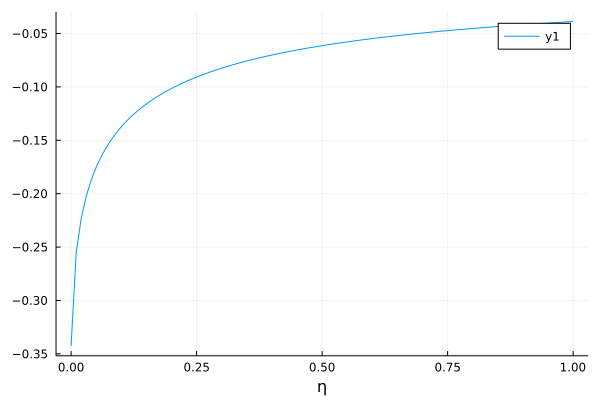

In [56]:
n_gamma = 10
η=0.3
ν=0.1
ηn = range(0,1,100)
lhsvector = zeros(length(ηn))
Threads.@threads for j in 1:length(ηn)
        lhsvector[j] = lhs(n_gamma, ηn[j], ν)
    end
plot(ηn, lhsvector)
xlabel!("η")

In [26]:
n_gamma = 100
η=0.3
ν=0.4
lhs(n_gamma, η, ν)
nn = 1:100
ηn = 0:0.1:1
lhsmatrix = zeros(10, length(nn))
Threads.@threads for j in nn
    for i in 1:10
        ii = 0.1*i
        lhsmatrix[i, j] = lhs(j, ii, ν)
    end
end

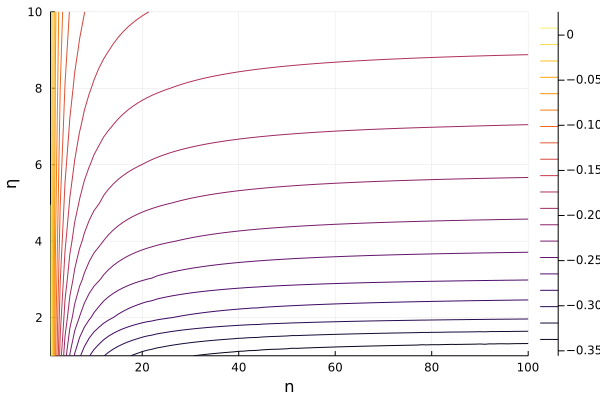

In [42]:
nlevels =20
contour(lhsmatrix, levels=nlevels, contour_labels=true)
xlabel!("n")
ylabel!("η")

 28.042116 seconds (55.55 M allocations: 3.245 GiB, 3.29% gc time, 99.98% compilation time)
  0.344829 seconds (717.67 k allocations: 42.250 MiB, 95.61% compilation time)


┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144


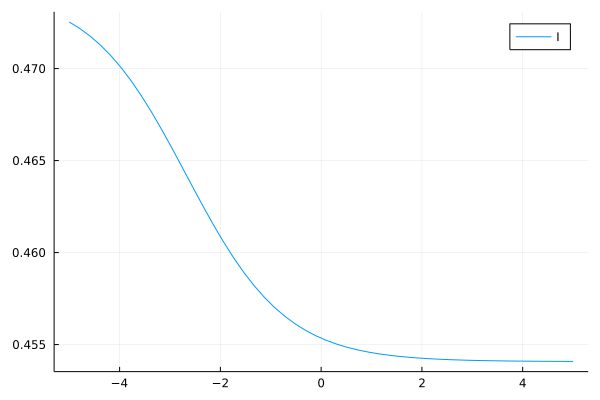

In [4]:
# 
function γ(x)
    y = exp(sin(2 * pi * x)) + (1 - x)
    return y
end
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end
dx = 0.05
n = 20

function ratio(x, η, ν)
    y = 1 + (η + x)^ν
    return y
end
prob = probgeneration!(ratio, γ, initS, initI, dx)
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]

@time episize!(prob, p, n);
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 50)
vartype = "I"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)

  0.063889 seconds (43.46 k allocations: 6.358 MiB, 51.42% compilation time)


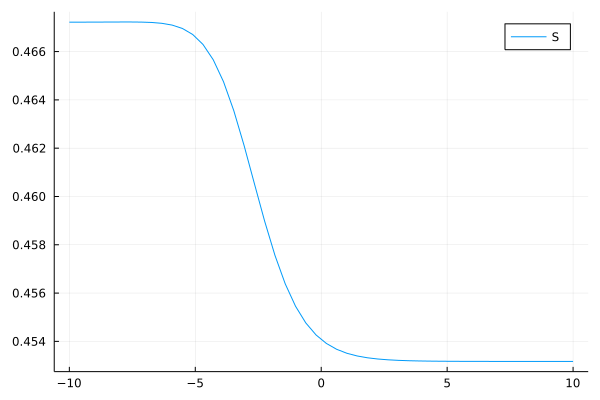

In [4]:
η = 0.3
ν = 0.4
p = [1.0, exp(10.0), η, ν]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
vartype = "S"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)

  1.136727 seconds (1.19 M allocations: 259.214 MiB, 13.28% compilation time)


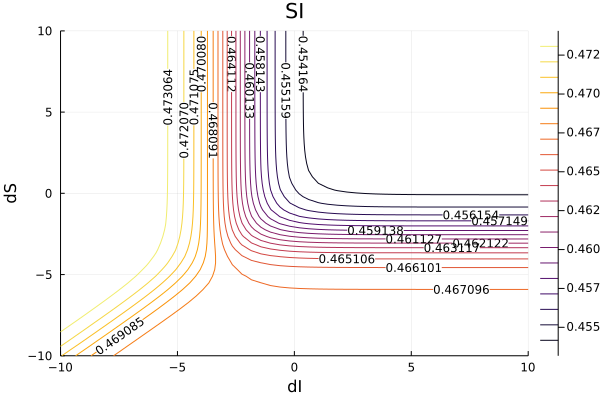

In [60]:
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]
nlevels = 20
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
leveltype = "SI"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("dI")
ylabel!("dS")

  0.334977 seconds (241.66 k allocations: 59.528 MiB)


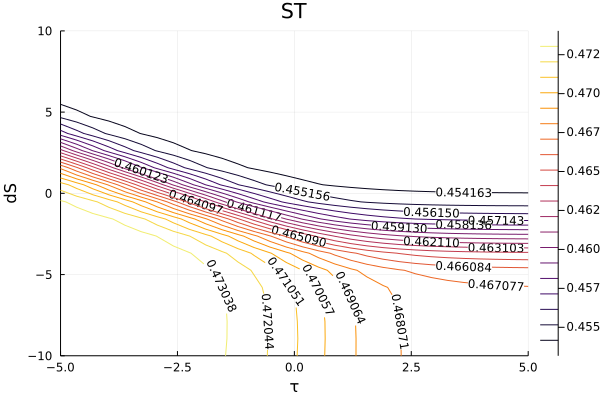

In [61]:
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 30)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "ST"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("τ")
ylabel!("dS")

  0.402857 seconds (239.72 k allocations: 59.230 MiB)


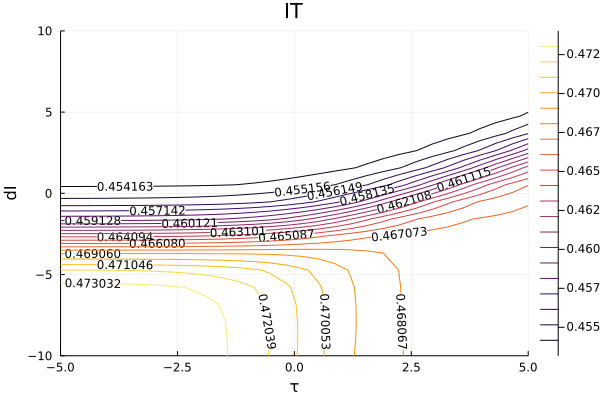

In [67]:
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 30)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "IT"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("τ")
ylabel!("dI")

  1.333440 seconds (1.03 M allocations: 251.729 MiB)


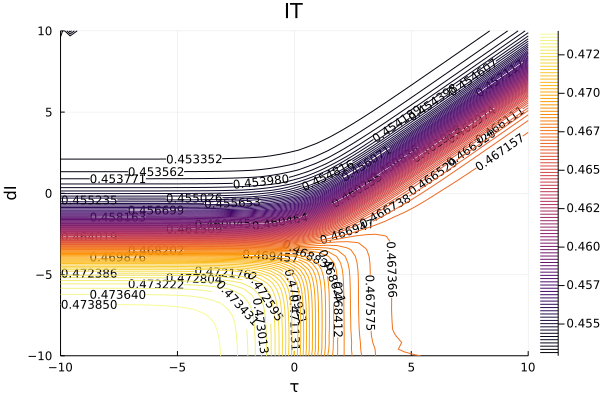

In [6]:
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
leveltype = "IT"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 100
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("τ")
ylabel!("dI")

In [1]:
η = 0.3
ν = 0.4
p = [1.0, 1.0, η, ν]
Ilim = Dict("min" => -10.0, "max" => 20.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "IT"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 100
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("τ")
ylabel!("dI")

LoadError: UndefVarError: levelset not defined

  0.032254 seconds (19.11 k allocations: 4.801 MiB)


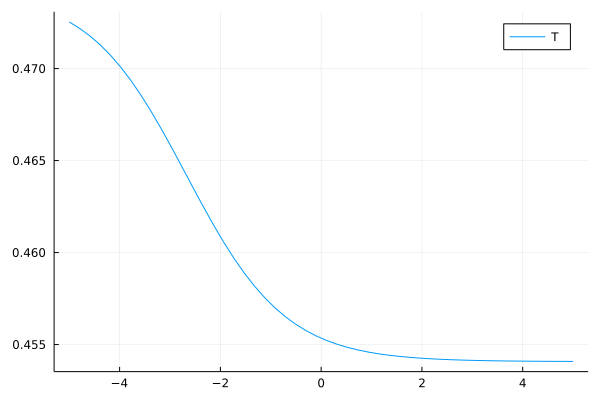

In [74]:
η = 0.3
ν = 0.4
p = [1.0, exp(-5.0), η, ν]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 50)
vartype = "T"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)